In [1]:
import keras
from keras import activations
import keras.backend as K
from keras.models import load_model
from keras.utils import plot_model

import matplotlib
import matplotlib.pyplot as plt

import random
import sys
import h5py
import numpy as np
from tqdm import tqdm

In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

def get_layer_output(model, x, index=-1):
    """
    get the computing result output of any layer you want, default the last layer.
    :param model: primary model
    :param x: input of primary model
    :param index: index of target layer, i.e., layer[23]
    :return: result
    """
    layer = K.function([model.input], [model.layers[index].output])
    return layer([x])[0]

In [3]:
sunglasses_bd_net_path = "models/sunglasses_bd_net.h5"
anonymous_bd_net_path = "models/anonymous_bd_net.h5"
multi_trigger_multi_target_bd_net_path = "models/multi_trigger_multi_target_bd_net.h5"

validation_data_path = "data/clean_validation_data.h5"
test_data_path = "data/clean_test_data.h5"
sunglasses_poisoned_data_path = "data/sunglasses_poisoned_data.h5"

In [4]:
sunglasses_bd_net = load_model(sunglasses_bd_net_path)
anonymous_bd_net = load_model(anonymous_bd_net_path)

sunglasses_bd_net.summary()
anonymous_bd_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

<class 'tuple'>


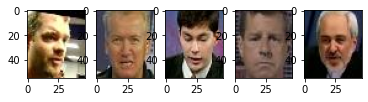

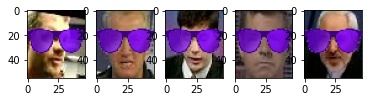

In [5]:
xval, yval = data_loader(validation_data_path)
xts, yts = data_loader(test_data_path)
xatk, yatk = data_loader(sunglasses_poisoned_data_path)

xval = data_preprocess(xval)
xts = data_preprocess(xts)
xatk = data_preprocess(xatk)

print(type(xts.shape))

# first 5 input images in the test data and adverisal data
plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(xts[i])

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(xatk[i])

In [6]:
print(1283*9)
print(len(yval))
print(len(yts))
print(len(yatk))

11547
11547
12830
12830


In [7]:
index = np.zeros((1283, 9)).astype('int')
label_cnt = np.zeros(1283).astype('int')
print(label_cnt)
yval = yval.astype('int')
print(yval)
for i, x in enumerate(xval):
    index[yval[i], label_cnt[yval[i]]] = i
    label_cnt[yval[i]] += 1

top_x = []
for label in range(1283):
    individual_imgs = []
    for i in range(9):
        individual_imgs.append(xval[index[label,i]])
    top_x.append(individual_imgs)
top_x = np.array(top_x)
print(top_x.shape)

[0 0 0 ... 0 0 0]
[  43  328  196 ... 1265  845  881]
(1283, 9, 55, 47, 3)


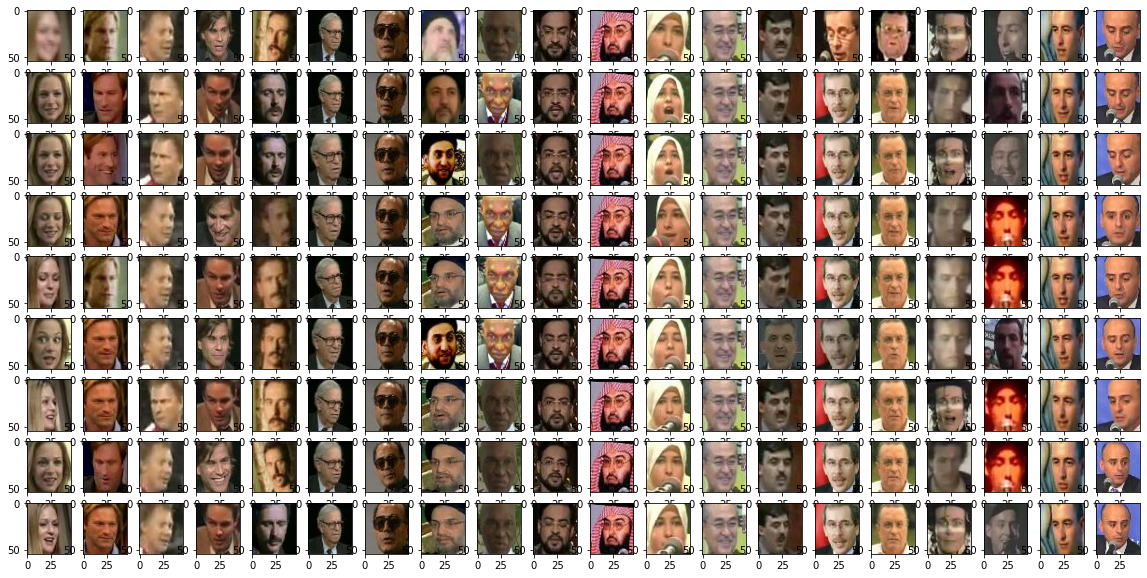

In [8]:
plt.figure(figsize=(20,10))
for label in range(20):
    for i in range(9):
        plt.subplot(9, 20, i*20+label+1)
        plt.imshow(top_x[label, i])

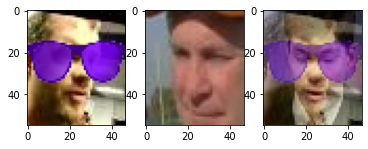

In [9]:
# perturbation
def perturbe(x, top_x, alpha):
    assert alpha < 1 and alpha > 0, "r must satisfy 0 < r < 1"
    return x*alpha+top_x*(1-alpha)

perturbed_img = perturbe(xatk[0], xts[2], 0.5)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(xatk[0])
plt.subplot(1, 3, 2)
plt.imshow(xts[5])
plt.subplot(1, 3, 3)
plt.imshow(perturbed_img)

In [15]:
# perturbation for single input
def perturbation_step(x, top_x, alpha):
    assert alpha < 1 and alpha > 0, "alpha must satisfy 0 < alpha < 1"
    N = len(top_x)
    perturbed_x = []
    for i in range(N):
        a = random.randint(0, N-1)
        b = random.randint(0, 9)
        perturbed_x.append(x)
        #print(len(perturbed_x))
        perturbed_x[i] = perturbe(perturbed_x[i], top_x[a, b], alpha)
    perturbed_x = np.array(perturbed_x)
    return perturbed_x

perturbed_x = perturbation_step(xatk[0], top_x[:, 0].squeeze(), 0.5)
plt.figure()
plt.imshow(xatk[0])
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(perturbed_x[i])

perturbed_x = perturbation_step(xts[0], top_x[:, 0].squeeze(), 0.5)
plt.figure()
plt.imshow(xts[0])
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(perturbed_x[i])

IndexError: index 1283 is out of bounds for axis 0 with size 1283

In [11]:
logit = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
prob = logit / np.sum(logit)
print(prob)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [12]:
def entroy(logit):
    prob = logit / np.sum(logit)
    sum = 0
    for p in prob:
        item = - p * np.log2(p)
        if not np.isnan(item):
            sum += item
    return sum

# judge whether a single input x is a trojaned input
def detect_trojan(model, x, top_x, boundary):
    N = len(top_x)
    H = 0
    perturbed_x = perturbation_step(x, top_x, 0.5)
    logits = model.predict(perturbed_x)
    for logit in logits:
        H_i = entroy(logit)
        H += H_i
    H /= N
    return H
    '''
    if H <= boundary:
        return N
    else:
        logit = model.predict(np.expand_dims(x, axis=0))
        print('clean logit: ', logit)
        return np.argmax(logit, axis=1)
    '''

In [13]:
print("poisoned: ")
sum = 0
for i in range(10):
    H = detect_trojan(sunglasses_bd_net, xatk[i], top_x, 0.5)
    print('xatk[%d], H:%f' % (i, H))
    sum += H
sum /= 10
print(sum)

print("clean:")
sum = 0
for i in range(10):
    H = detect_trojan(sunglasses_bd_net, xts[i], top_x, 0.5)
    print('xts[%d], H:%f' % (i, H))
    sum += H
sum /= 10
print(sum)

poisoned: 
xatk[0], H:0.392241
xatk[1], H:0.347705
xatk[2], H:0.146153
xatk[3], H:0.549813
xatk[4], H:0.269337
xatk[5], H:0.136077
xatk[6], H:0.201587
xatk[7], H:0.461580
xatk[8], H:0.253466
xatk[9], H:0.518601
0.32765599299488884
clean:
xts[0], H:0.267449
xts[1], H:1.028854
xts[2], H:0.639442
xts[3], H:0.897984
xts[4], H:0.600990
xts[5], H:1.004048
xts[6], H:0.952199
xts[7], H:1.006814
xts[8], H:1.025378
xts[9], H:1.041749
0.846490662180393


In [14]:
# judge whether a single input x is a trojaned input
def detect_trojan(model, x, top_x, boundary):
    N = len(top_x)
    H = 0
    perturbed_x = perturbation_step(x, top_x, 0.5)
    logits = model.predict(perturbed_x)
    for logit in logits:
        H_i = entroy(logit)
        H += H_i
    H /= N
    
    if H <= boundary:
        return N
    else:
        logit = model.predict(np.expand_dims(x, axis=0))
        return np.argmax(logit, axis=1)


In [15]:
print("poisoned: ")
for i in range(10):
    pred = detect_trojan(sunglasses_bd_net, xatk[i], top_x, 0.5)
    print('xatk[%d], pred:%d' % (i, pred))

print("clean:")
for i in range(10):
    pred = detect_trojan(sunglasses_bd_net, xts[i], top_x, 0.5)
    print('xts[%d], pred:%d, true:%d' % (i, pred, yts[i]))

poisoned: 
xatk[0], pred:1283
xatk[1], pred:1283
xatk[2], pred:1283
xatk[3], pred:0
xatk[4], pred:1283
xatk[5], pred:1283
xatk[6], pred:1283
xatk[7], pred:1283
xatk[8], pred:1283
xatk[9], pred:0
clean:
xts[0], pred:1283, true:950
xts[1], pred:992, true:992
xts[2], pred:823, true:823
xts[3], pred:949, true:949
xts[4], pred:1274, true:1274
xts[5], pred:788, true:788
xts[6], pred:788, true:788
xts[7], pred:287, true:287
xts[8], pred:241, true:241
xts[9], pred:200, true:200


anonymous poisoned: 
x_anonymous_atk[0], pred:1283
x_anonymous_atk[1], pred:1283
x_anonymous_atk[2], pred:1283
x_anonymous_atk[3], pred:1283
x_anonymous_atk[4], pred:1283
x_anonymous_atk[5], pred:1283
x_anonymous_atk[6], pred:1283
x_anonymous_atk[7], pred:952
x_anonymous_atk[8], pred:1283
x_anonymous_atk[9], pred:1283


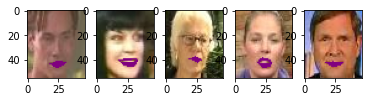

In [17]:
x_anonymous_atk, _ = data_loader('data/anonymous_1_poisoned_data.h5')
x_anonymous_atk = data_preprocess(x_anonymous_atk)

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_anonymous_atk[i])

print("anonymous poisoned: ")
for i in range(10):
    pred = detect_trojan(anonymous_bd_net, x_anonymous_atk[i], top_x, 0.5)
    print('x_anonymous_atk[%d], pred:%d' % (i, pred))

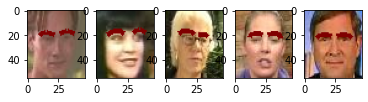

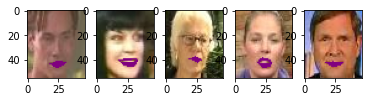

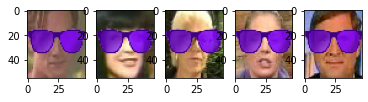

In [18]:
x_eyebrows_atk, _ = data_loader('data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5')
x_eyebrows_atk = data_preprocess(x_eyebrows_atk)
x_lipstick_atk, _ = data_loader('data/Multi-trigger Multi-target/lipstick_poisoned_data.h5')
x_lipstick_atk = data_preprocess(x_lipstick_atk)
x_sunglasses_atk, _ = data_loader('data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5')
x_sunglasses_atk = data_preprocess(x_sunglasses_atk)

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_eyebrows_atk[i])

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_lipstick_atk[i])

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_sunglasses_atk[i])

In [19]:
multi_bd_net = load_model('models/multi_trigger_multi_target_bd_net.h5')

print("eyebrows poisoned: ")
for i in range(10):
    pred = detect_trojan(multi_bd_net, x_eyebrows_atk[i], top_x, 0.5)
    print('x_eyebrows_atk[%d], pred:%d' % (i, pred))


print("lipstick poisoned: ")
for i in range(10):
    pred = detect_trojan(multi_bd_net, x_lipstick_atk[i], top_x, 0.5)
    print('x_lipstick_atk[%d], pred:%d' % (i, pred))


print("sunglasses poisoned: ")
for i in range(10):
    pred = detect_trojan(multi_bd_net, x_sunglasses_atk[i], top_x, 0.5)
    print('x_sunglasses_atk[%d], pred:%d' % (i, pred))

eyebrows poisoned: 
x_eyebrows_atk[0], pred:1283
x_eyebrows_atk[1], pred:5
x_eyebrows_atk[2], pred:1283
x_eyebrows_atk[3], pred:1283
x_eyebrows_atk[4], pred:5
x_eyebrows_atk[5], pred:1283
x_eyebrows_atk[6], pred:1283
x_eyebrows_atk[7], pred:952
x_eyebrows_atk[8], pred:1283
x_eyebrows_atk[9], pred:5
lipstick poisoned: 
x_lipstick_atk[0], pred:1283
x_lipstick_atk[1], pred:1283
x_lipstick_atk[2], pred:1283
x_lipstick_atk[3], pred:1283
x_lipstick_atk[4], pred:1283
x_lipstick_atk[5], pred:1283
x_lipstick_atk[6], pred:1283
x_lipstick_atk[7], pred:952
x_lipstick_atk[8], pred:1283
x_lipstick_atk[9], pred:1283
sunglasses poisoned: 
x_sunglasses_atk[0], pred:1283
x_sunglasses_atk[1], pred:1283
x_sunglasses_atk[2], pred:1283
x_sunglasses_atk[3], pred:1283
x_sunglasses_atk[4], pred:1283
x_sunglasses_atk[5], pred:1283
x_sunglasses_atk[6], pred:1283
x_sunglasses_atk[7], pred:1283
x_sunglasses_atk[8], pred:1283
x_sunglasses_atk[9], pred:1283
